In [3]:
from numpy import array
import pandas as pd
import pickle
import numpy as np
import os
import cv2

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu


In [5]:
image_tokens=pd.read_csv("dataset/all_captions/Flickr8k.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("dataset/all_captions/Flickr_8k.trainImages.txt",names=["img_id"])

In [6]:
l=os.listdir("dataset/all_images/Flicker8k_Dataset")
print(len(l))

8091


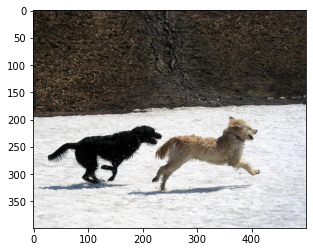

In [7]:
img=cv2.imread("dataset/all_images/Flicker8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [8]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [9]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [10]:
image_tokens.head()

,img_id,img_caption
0,1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,<start> A little girl in a pink dress going in...


In [11]:
train_image_names.head()

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


In [12]:
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:16<00:00, 488.33it/s]


In [ ]:
model1=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model1.summary()

In [ ]:
path="dataset/all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model1.predict(x)
  train_features[image_name]=features.squeeze()

In [ ]:
infile = open("train_features.txt",'wb')
pickle.dump(train_features, infile)
infile.close()

In [13]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 802123.54it/s]


2808249
9486


In [14]:
vocab_size=len(unique_words)+1
max_length=40

In [ ]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [ ]:
infile = open("w2_ix.txt",'wb')
pickle.dump(words_to_indices, infile)
infile.close()

infile = open("ix_2w.txt",'wb')
pickle.dump(indices_to_words, infile)
infile.close()

In [20]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|███████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 66717.50it/s]


In [21]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

[[2763, 9463, 3289, 7825, 2521, 5454, 3974, 8309, 7955, 7825, 3162, 8964, 6608, 686, 9387], [2763, 9197, 7825, 1472, 2394, 7825, 2169, 6608, 9387], [2763, 3323, 9353, 6262, 639, 6198, 4993, 8964, 1789, 942, 686, 9387], [2763, 3323, 9353, 306, 9312, 3162, 8964, 6608, 686, 9387], [2763, 3323, 9353, 5454, 2169, 8309, 9443, 2614, 5924, 6422, 7741, 686, 9387]]


In [22]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|███████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 32157.69it/s]


In [23]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

[[2763 9463 3289 7825 2521 5454 3974 8309 7955 7825 3162 8964 6608  686
  9387    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2763 9197 7825 1472 2394 7825 2169 6608 9387    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2763 3323 9353 6262  639 6198 4993 8964 1789  942  686 9387    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2763 3323 9353  306 9312 3162 8964 6608  686 9387    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2763 3323 9353 5454 2169 8309 9443 2614 5924 6422 7741  686 9387    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [24]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dogs
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [25]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[2763]

In [17]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in train_encoded_captions:
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield ([array(X1), array(X2)], array(Y))
      X1, X2, Y = list(), list(), list()
      n=0

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

In [ ]:
for i in train_features:
  print(train_features[i].shape)
  break

In [ ]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
len(train_encoded_captions)

In [ ]:
epochs=1
no_of_photos=15
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

In [26]:
epochs=100
no_of_photos=15
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  print("EPOCH :", str(i))
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

EPOCH : 0


C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


533/533 [==============================] - 698s 1s/step - loss: 0.3844 - accuracy: 0.8873
EPOCH : 1
533/533 [==============================] - 785s 1s/step - loss: 0.3849 - accuracy: 0.8874
EPOCH : 2
533/533 [==============================] - 241s 450ms/step - loss: 0.3833 - accuracy: 0.8879
EPOCH : 3
533/533 [==============================] - 224s 420ms/step - loss: 0.3837 - accuracy: 0.8876
EPOCH : 4
533/533 [==============================] - 226s 424ms/step - loss: 0.3828 - accuracy: 0.8877
EPOCH : 5
533/533 [==============================] - 225s 422ms/step - loss: 0.3823 - accuracy: 0.8878
EPOCH : 6
533/533 [==============================] - 224s 421ms/step - loss: 0.3815 - accuracy: 0.8882
EPOCH : 7
533/533 [==============================] - 228s 427ms/step - loss: 0.3820 - accuracy: 0.8881
EPOCH : 8
533/533 [==============================] - 235s 441ms/step - loss: 0.3816 - accuracy: 0.8881
EPOCH : 9
533/533 [==============================] - 231s 432ms/step - loss: 0.3812 - acc

533/533 [==============================] - 224s 421ms/step - loss: 0.3595 - accuracy: 0.8934
EPOCH : 80
533/533 [==============================] - 224s 420ms/step - loss: 0.3596 - accuracy: 0.8936
EPOCH : 81
533/533 [==============================] - 224s 420ms/step - loss: 0.3601 - accuracy: 0.8933
EPOCH : 82
533/533 [==============================] - 225s 422ms/step - loss: 0.3610 - accuracy: 0.8932
EPOCH : 83
533/533 [==============================] - 225s 423ms/step - loss: 0.3588 - accuracy: 0.8936
EPOCH : 84
533/533 [==============================] - 224s 420ms/step - loss: 0.3575 - accuracy: 0.8941
EPOCH : 85
533/533 [==============================] - 223s 419ms/step - loss: 0.3582 - accuracy: 0.8938
EPOCH : 86
533/533 [==============================] - 227s 426ms/step - loss: 0.3584 - accuracy: 0.8938
EPOCH : 87
533/533 [==============================] - 223s 418ms/step - loss: 0.3581 - accuracy: 0.8938
EPOCH : 88
533/533 [==============================] - 224s 420ms/step - los

In [27]:
model.save("scene.h5")

In [28]:
from tensorflow.keras.models import load_model
import pickle

model = load_model("scene.h5")

infile1 = open("w2_ix.txt",'rb')
words_to_indices = pickle.load(infile1)
infile1.close()

infile2 = open("ix_2w.txt",'rb')
indices_to_words = pickle.load(infile2)
infile2.close()

infile3 = open("train_features.txt",'rb')
train_features = pickle.load(infile3)
infile3.close()

In [29]:
max_length=40
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  return final

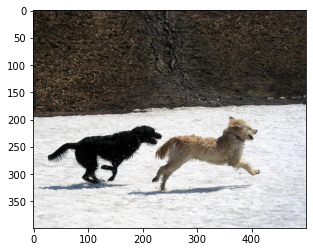

Referance Captions: 
A black dog is running after a white dog in the snow .
Black dog chasing brown dog through snow
Two dogs chase each other across the snowy ground .
Two dogs play together in the snow .
Two dogs running through a low lying body of water .
Predicted Caption: 
Two dogs are running through the snow .
bleu score:  6.562069055463047e-78


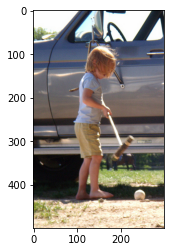

Referance Captions: 
A little baby plays croquet .
A little girl plays croquet next to a truck .
The child is playing croquette by the truck .
The kid is in front of a car with a put and a ball .
The little boy is playing with a croquet hammer and ball beside the car .
Predicted Caption: 
A little boy in a yellow shirt is playing croquette by the house .
bleu score:  0.3336118221483976


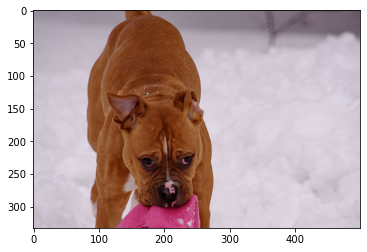

Referance Captions: 
A brown dog in the snow has something hot pink in its mouth .
A brown dog in the snow holding a pink hat .
A brown dog is holding a pink shirt in the snow .
A dog is carrying something pink in its mouth while walking through the snow .
A dog with something pink in its mouth is looking forward .
Predicted Caption: 
A dog is in the snow .
bleu score:  0.335783404331301


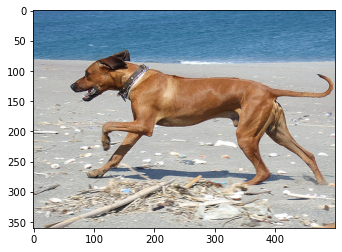

Referance Captions: 
A brown dog is running along a beach .
A brown dog wearing a black collar running across the beach .
A dog walks on the sand near the water .
Brown dog running on the beach .
The large brown dog is running on the beach by the ocean .
Predicted Caption: 
A brown dog runs along the beach near the ocean .
bleu score:  7.206470625226315e-78


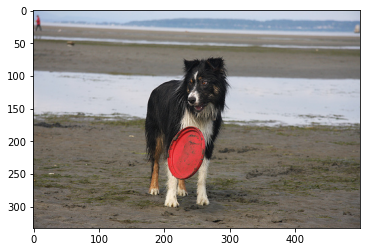

Referance Captions: 
A black and white dog with a red Frisbee standing on a sandy beach .
A dog drops a red disc on a beach .
A dog with a red Frisbee flying in the air .
Dog catching a red Frisbee .
The black dog is dropping a red disc on a beach .
Predicted Caption: 
A dog runs along the beach .
bleu score:  1.04198122363916e-154


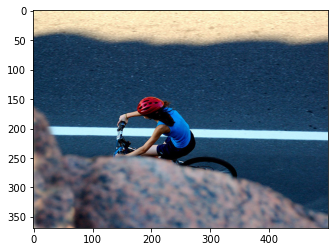

Referance Captions: 
A cyclist wearing a red helmet is riding on the pavement .
A girl is riding a bike on the street while wearing a red helmet .
A person on a bike wearing a red helmet , riding down a street .
A woman wears a red helmet and blue shirt as she goes for a bike ride in the shade .
Person in blue shirt and red helmet riding bike down the road
Predicted Caption: 
A cyclist is riding down a path in a red and yellow outfit .
bleu score:  4.529941434898427e-78


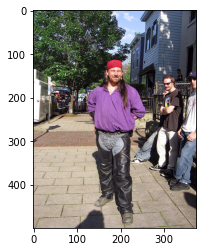

Referance Captions: 
A man dressed in a purple shirt and red bandanna smiles at the people watching him .
A man on the street wearing leather chaps and a chainmail codpiece .
A man wearing a purple shirt and black leather chaps poses for the camera .
Man dressed in leather chaps and purple shirt stands in front of onlookers
There is a man in a purple shirt , leather chaps and a red bandanna , standing near other men .
Predicted Caption: 
A man in a blue shirt and leather chaps is passing by a seated man in denim " .
bleu score:  3.892737901375037e-78


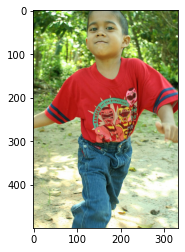

Referance Captions: 
A boy wearing a red t-shirt is running through woodland .
A child runs near some trees .
A young boy is dancing around .
A young boy with a red short sleeved shirt and jeans runs by some trees .
The little boy in the red shirt stops to smile for the camera .
Predicted Caption: 
A boy in a red shirt is dancing with a dog .
bleu score:  1.2248038575119736e-154


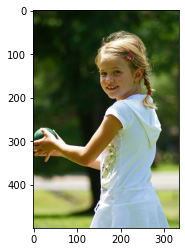

Referance Captions: 
A girl in a white dress .
A little girl in white is looking back at the camera while carrying a water grenade .
A smiling young girl in braids is playing ball .
A young girl wearing white looks at the camera as she plays .
The girl is holding a green ball .
Predicted Caption: 
A little girl in a green dress is running through a yard .
bleu score:  0.2978201796359045


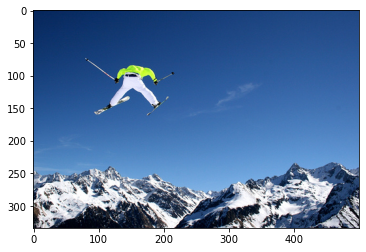

Referance Captions: 
A skier in a yellow jacket is airborne above the mountains .
A skier jumps high in the air with a view of the mountains .
A skiing man in a fluorescent jacket jumps very high and it looks as though he is flying .
Somone is high in the air doing a ski jump .
The skier in the green jacket and white pants appears to almost fly into the sky .
Predicted Caption: 
A skier is flying skiing in the air above a snowy field .
bleu score:  4.887310777383362e-78


In [30]:
i=0
for img_id in train_features:
  i+=1
  img=cv2.imread("dataset/all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=train_features[img_id]
  plt.show()
  reference=[]
  for caps in train_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==10):
    break

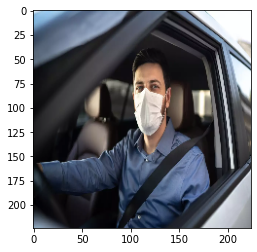

Predicted Caption: 
A man in a blue shirt and glasses gives a video camera on a train .


In [31]:
model1 =ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

img=cv2.imread('test.jpg')
img = cv2.resize(img,(224,224))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = model1.predict(x)
photo = features.squeeze()
plt.show()
candidate=greedy_search(photo)
print("Predicted Caption: ")
print(" ".join(candidate))